In [32]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import classification_report
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
import numpy as np
import pandas as pd

In [2]:


df = pd.read_csv("/content/drive/MyDrive/5gml/Zoom_1.csv")
print(df.head())
print(df.columns)


   No.                        Time     Source    Destination Protocol  Length  \
0    2  2022-05-30 16:01:36.328035  192.0.0.2  144.195.34.97      UDP     936   
1    3  2022-05-30 16:01:36.332697  192.0.0.2  144.195.34.97      UDP     593   
2    4  2022-05-30 16:01:36.332777  192.0.0.2  144.195.34.97      UDP     593   
3    5  2022-05-30 16:01:36.332821  192.0.0.2  144.195.34.97      UDP     592   
4    6  2022-05-30 16:01:36.332849  192.0.0.2  144.195.34.97      UDP     592   

                     Info  
0  47018  >  8801 Len=908  
1  47018  >  8801 Len=565  
2  47018  >  8801 Len=565  
3  47018  >  8801 Len=564  
4  47018  >  8801 Len=564  
Index(['No.', 'Time', 'Source', 'Destination', 'Protocol', 'Length', 'Info'], dtype='object')


In [36]:
qos_df.isna().sum()


,0
time_window,0
packet_count,0
avg_packet_size,0
total_bytes,0
std_packet_size,0
throughput_mbps,0


In [37]:
qos_df.describe()


,time_window,packet_count,avg_packet_size,total_bytes,std_packet_size,throughput_mbps
count,21145.000000,21145.000000,21145.000000,21145.000000,21145.000000,21145.000000
mean,10572.000000,288.254339,667.770387,195941.348073,359.354556,1.567531
std,6104.180057,42.004386,97.221399,49501.286678,32.072482,0.396010
min,0.000000,70.000000,121.214286,8485.000000,9.681737,0.067880
25%,5286.000000,259.000000,620.747036,158701.000000,350.735998,1.269608
50%,10572.000000,305.000000,690.965944,213903.000000,363.884284,1.711224
75%,15858.000000,319.000000,744.703364,238368.000000,376.265485,1.906944
max,21144.000000,388.000000,859.301818,287108.000000,537.321800,2.296864


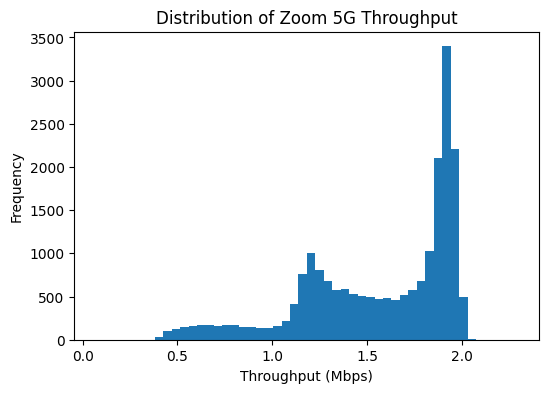

In [38]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.hist(qos_df['throughput_mbps'], bins=50)
plt.xlabel("Throughput (Mbps)")
plt.ylabel("Frequency")
plt.title("Distribution of Zoom 5G Throughput")
plt.show()


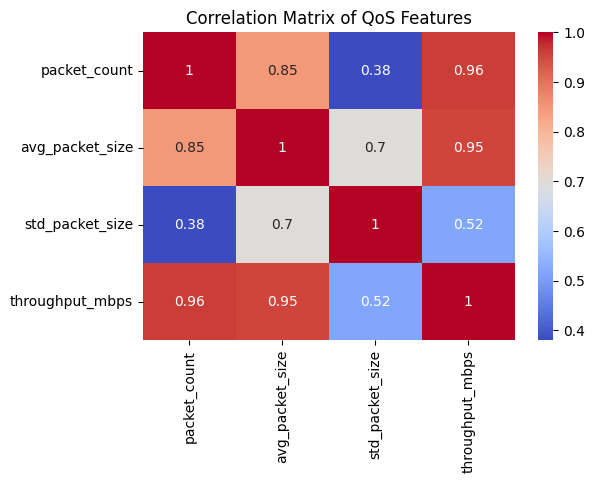

In [39]:
import seaborn as sns

features = ['packet_count', 'avg_packet_size', 'std_packet_size', 'throughput_mbps']
corr = qos_df[features].corr()

plt.figure(figsize=(6,4))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix of QoS Features")
plt.show()


In [3]:
df = df.drop(columns=['No.', 'Source', 'Destination', 'Protocol', 'Info'])


In [ ]:
df['Time'] = pd.to_datetime(df['Time'])
df['Time_sec'] = (df['Time'] - df['Time'].min()).dt.total_seconds()
df = df.drop(columns=['Time'])


In [10]:
df['time_window'] = df['Time_sec'].astype(int)


In [11]:
qos_df = df.groupby('time_window').agg(
    packet_count=('Length', 'count'),
    avg_packet_size=('Length', 'mean'),
    total_bytes=('Length', 'sum'),
    std_packet_size=('Length', 'std')
).reset_index()


In [12]:
qos_df['throughput_mbps'] = (qos_df['total_bytes'] * 8) / 1_000_000


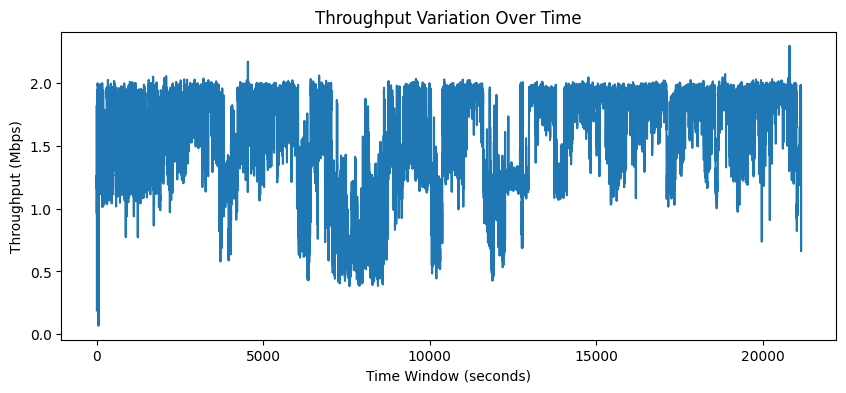

In [40]:
plt.figure(figsize=(10,4))
plt.plot(qos_df['time_window'], qos_df['throughput_mbps'])
plt.xlabel("Time Window (seconds)")
plt.ylabel("Throughput (Mbps)")
plt.title("Throughput Variation Over Time")
plt.show()


In [13]:
X = qos_df[['packet_count', 'avg_packet_size', 'std_packet_size']]
y = qos_df['throughput_mbps']


In [41]:
qos_df['burst'] = qos_df['packet_count'] > qos_df['packet_count'].quantile(0.9)


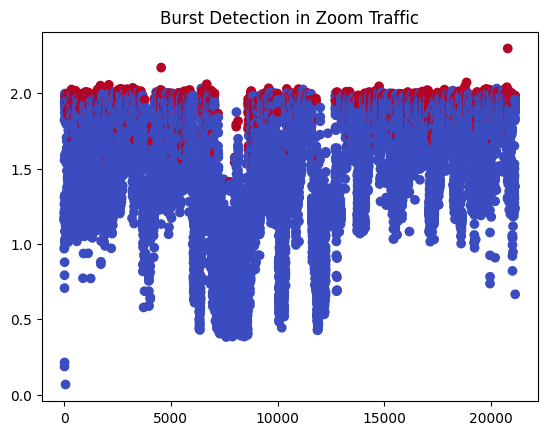

In [42]:
plt.scatter(qos_df['time_window'], qos_df['throughput_mbps'],
            c=qos_df['burst'], cmap='coolwarm')
plt.title("Burst Detection in Zoom Traffic")
plt.show()


In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [19]:


model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, pred))
print("RMSE:", rmse)
print("Throughput range:")
print("Min:", y_test.min())
print("Max:", y_test.max())


RMSE: 0.005028113605628875
Throughput range:
Min: 0.06788
Max: 2.035624


In [30]:

lr = LinearRegression()
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)

lr_rmse = np.sqrt(mean_squared_error(y_test, lr_pred))
print("Linear Regression RMSE:", lr_rmse)


Linear Regression RMSE: 0.030841071763971203


In [33]:
gbr = GradientBoostingRegressor(random_state=42)
gbr.fit(X_train, y_train)
gbr_pred = gbr.predict(X_test)

gbr_rmse = np.sqrt(mean_squared_error(y_test, gbr_pred))
print("Gradient Boosting RMSE:", gbr_rmse)

Gradient Boosting RMSE: 0.012747340735561283


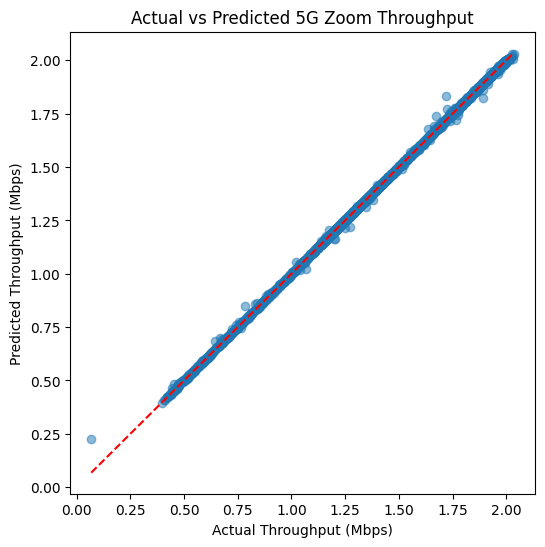

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.scatter(y_test, pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'r--')
plt.xlabel("Actual Throughput (Mbps)")
plt.ylabel("Predicted Throughput (Mbps)")
plt.title("Actual vs Predicted 5G Zoom Throughput")
plt.show()


In [43]:
def qoe_score(throughput):
    if throughput < 0.7:
        return 1   # Bad experience
    elif throughput < 1.4:
        return 3   # Average experience
    else:
        return 5   # Excellent experience

qos_df['qoe'] = qos_df['throughput_mbps'].apply(qoe_score)


In [23]:


mae = mean_absolute_error(y_test, pred)
r2 = r2_score(y_test, pred)

print("MAE:", mae)
print("R² Score:", r2)


MAE: 0.0015937684558997114
R² Score: 0.999843209209407


In [35]:


results = pd.DataFrame({
    "Model": ["Linear Regression", "Random Forest", "Gradient Boosting"],
    "RMSE": [lr_rmse, rmse, gbr_rmse]
})

print(results)


               Model      RMSE
0  Linear Regression  0.030841
1      Random Forest  0.005028
2  Gradient Boosting  0.012747


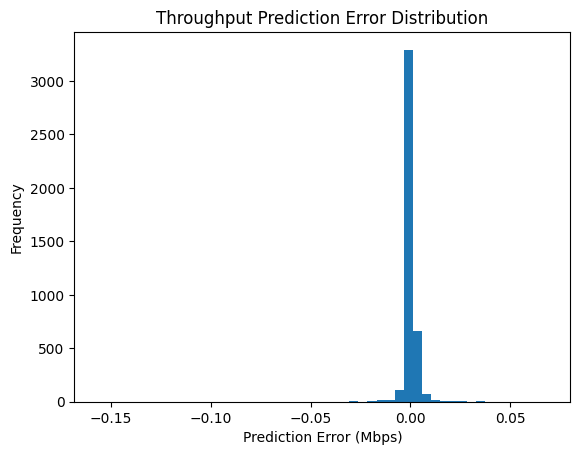

In [24]:
errors = y_test - pred

plt.hist(errors, bins=50)
plt.xlabel("Prediction Error (Mbps)")
plt.ylabel("Frequency")
plt.title("Throughput Prediction Error Distribution")
plt.show()


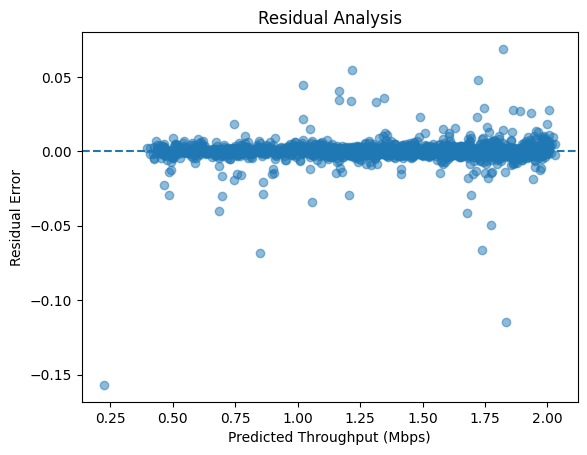

In [25]:
plt.scatter(pred, errors, alpha=0.5)
plt.axhline(0, linestyle='--')
plt.xlabel("Predicted Throughput (Mbps)")
plt.ylabel("Residual Error")
plt.title("Residual Analysis")
plt.show()


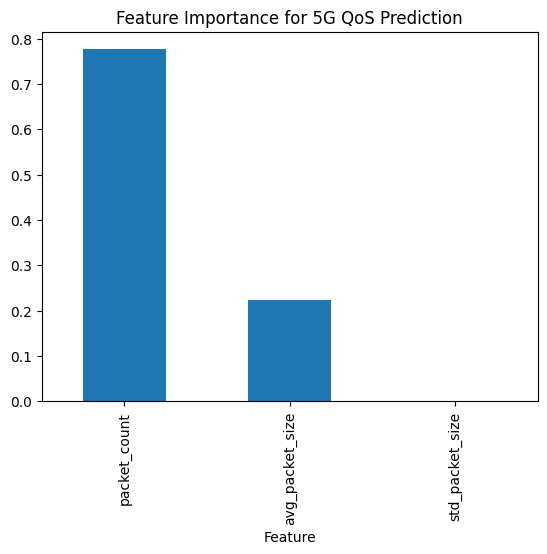

In [26]:

importance_df = pd.DataFrame({
    "Feature": X.columns,
    "Importance": model.feature_importances_
}).sort_values(by="Importance", ascending=False)

importance_df.plot(
    x="Feature",
    y="Importance",
    kind="bar",
    legend=False,
    title="Feature Importance for 5G QoS Prediction"
)
plt.show()

In [27]:
import pandas as pd

def qos_class(x):
    if x < 0.7:
        return 0   # Poor
    elif x < 1.4:
        return 1   # Medium
    else:
        return 2   # Good

# Actual and predicted QoS classes
y_test_cls = y_test.apply(qos_class)
pred_cls = pd.Series(pred).apply(qos_class)


In [29]:
from sklearn.metrics import classification_report

print(classification_report(
    y_test_cls,
    pred_cls,
    target_names=["Poor", "Medium", "Good"]
))


              precision    recall  f1-score   support

        Poor       1.00      0.99      0.99       207
      Medium       1.00      1.00      1.00      1240
        Good       1.00      1.00      1.00      2782

    accuracy                           1.00      4229
   macro avg       1.00      1.00      1.00      4229
weighted avg       1.00      1.00      1.00      4229

